## INFO 2950 Group Project Phase 2

Nichole Zheng (nz268) & Hedy Song (ys565)

### Chosen Dataset:
The dataset is a collection of daily records of the top trending videos on YouTube across multiple countries. It contains metadata such as video titles, channel names, publish times, tags, views, likes, dislikes, comment counts, and descriptions. Each region’s data is stored in a separate CSV file, and accompanying JSON files provide mappings of category IDs to video categories. 

It can be found at: https://www.kaggle.com/datasets/datasnaek/youtube-new/data

In terms of availability, the dataset is freely available and downloadable from Kaggle at the above link. It is provided in CSV format, organized by country. It was originally collected using the YouTube Data API (documentation: YouTube Data API v3). 

Below is the column names and their corresponding description

- **video_id：** Unique identifier for each YouTube video.
- **trending_date:** Date when the video appeared on the trending list (YYYY-MM-DD format).
- **title:** Title of the YouTube video.
- **channel_title:** Name of the channel that uploaded the video.
- **category_id:** Numeric ID representing the video’s category (e.g., entertainment, music, news).
- **publish_time:** Exact timestamp when the video was originally published on YouTube (UTC).
- **tags:** List of keywords or tags associated with the video.
- **views:** Total number of views the video had when it was trending.
- **likes:** Number of likes the video received.
- **dislikes:** Number of dislikes the video received.
- **comment_count:** Number of comments posted on the video.
- **thumbnail_link:** URL of the video’s thumbnail image.
- **comments_disabled:** Boolean flag indicating whether comments were disabled (True/False).
- **ratings_disabled:** Boolean flag showing whether viewers were prevented from rating (liking/disliking) the video.
- **video_error_or_removed:** Boolean flag showing whether the video was later removed or produced an error.
- **description:** Text description provided by the uploader. May contain keywords, links, or summaries of the video’s content.


## Research Question:
**What factors predict how long a YouTube video stays trending for the time period 2017-2018 in the United States?**

Reasoning behind:
- We want to just focus on the *US Youtube dataset* for now, and if time permits later, we can do analysis on other countries and use the US findings as baseline and see how cultural difference affects how long a video stays trending.
- Our analysis later showed that the majority of the videos are published in the year of *2017 and 2018*, so we choose to narrow down our analysis for this time period.

### Explore the original dataset before cleaning

All the necessary modules are imported, and the dataset is loaded. The first 5 rows are printed out for sanity check.

In [1]:
import pandas as pd
from datetime import datetime
import json
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
df = pd.read_csv("USvideos.csv", encoding='utf-8')
print(df.head())

      video_id trending_date  \
0  2kyS6SvSYSE      17.14.11   
1  1ZAPwfrtAFY      17.14.11   
2  5qpjK5DgCt4      17.14.11   
3  puqaWrEC7tY      17.14.11   
4  d380meD0W0M      17.14.11   

                                               title          channel_title  \
0                 WE WANT TO TALK ABOUT OUR MARRIAGE           CaseyNeistat   
1  The Trump Presidency: Last Week Tonight with J...        LastWeekTonight   
2  Racist Superman | Rudy Mancuso, King Bach & Le...           Rudy Mancuso   
3                   Nickelback Lyrics: Real or Fake?  Good Mythical Morning   
4                           I Dare You: GOING BALD!?               nigahiga   

   category_id              publish_time  \
0           22  2017-11-13T17:13:01.000Z   
1           24  2017-11-13T07:30:00.000Z   
2           23  2017-11-12T19:05:24.000Z   
3           24  2017-11-13T11:00:04.000Z   
4           24  2017-11-12T18:01:41.000Z   

                                                tags    views   lik

The below two commands are part of the initial exploratory data inspection step. They help to ensure we understood the dataset’s structure, completeness, and scale before performing deeper analysis or visualization.

This dataset contains information about 40,949 YouTube videos, including their metadata, publication details, engagement metrics, and trending status. Each row represents a single video entry that appeared on the trending list.

In [3]:
df.info()
print('This is the shape of the df:', df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40949 entries, 0 to 40948
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   video_id                40949 non-null  object
 1   trending_date           40949 non-null  object
 2   title                   40949 non-null  object
 3   channel_title           40949 non-null  object
 4   category_id             40949 non-null  int64 
 5   publish_time            40949 non-null  object
 6   tags                    40949 non-null  object
 7   views                   40949 non-null  int64 
 8   likes                   40949 non-null  int64 
 9   dislikes                40949 non-null  int64 
 10  comment_count           40949 non-null  int64 
 11  thumbnail_link          40949 non-null  object
 12  comments_disabled       40949 non-null  bool  
 13  ratings_disabled        40949 non-null  bool  
 14  video_error_or_removed  40949 non-null  bool  
 15  de

## A. Data Cleaning:

#### 1. Handle Duplicates, Missing Values, and Invalid Entries

Result:

- The dataset contains no duplicates.
- The description column has 570 missing values.
- Any negative values in views, likes, dislikes, or comment_count (if present) were removed.

In [4]:
# Check for duplicates
df.duplicated().sum()
# check for missing values
df.isna().sum()

video_id                    0
trending_date               0
title                       0
channel_title               0
category_id                 0
publish_time                0
tags                        0
views                       0
likes                       0
dislikes                    0
comment_count               0
thumbnail_link              0
comments_disabled           0
ratings_disabled            0
video_error_or_removed      0
description               570
dtype: int64

In [5]:
# Remove invalid values
df = df[(df['views'] >= 0) & (df['likes'] >= 0) & (df['dislikes'] >= 0) & (df['comment_count'] >= 0)]

#### 2. Drop Unnecessary Columns

This dataset contains no duplicates, though there are a few null values in the description column. We will be **dropping the description column** because:
1. Many **unique strings** of dataset making it hard to compare
2. Only a **few null values** therefore can't do binary variable to compare if having versus not having a description is a factor that decides whether a video goes viral 

The **thumbnail_link column** is also dropped, as extracting and analyzing cover images with an LLM would be too resource-intensive. Instead, we will focus our research on other variables, such as title and tags.

In [6]:
df = df.drop(['thumbnail_link','description'], axis=1)

#### 3. Date Conversion

Converted trending_date and publish_time to **standard datetime formats** and **removed the timezone information** to ensure consistency across all records.

All datetime are now in the format: YYYY-MM-DD (ex: 2017-11-14)

In [7]:
df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m', errors='coerce')
df['publish_time'] = pd.to_datetime(df['publish_time'], errors='coerce')

# Ensure both datetime columns are timezone-naive (remove timezone info)
df['publish_time'] = pd.to_datetime(df['publish_time'], utc=True).dt.tz_localize(None)
df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m', errors='coerce')

#### 4. Map the corresponding category ID to category name

Initially, US_videos.csv contained all video information, while a separate JSON file mapped category IDs (int64) to their corresponding names. To efficiently analyze videos by category, we replaced each category ID with its category name.

In [8]:
# Load JSON file
with open("US_category_id.json", "r") as f:
    data = json.load(f)

# Extract mapping: category_id → category_name
category_mapping = {int(item['id']): item['snippet']['title'] for item in data['items']}

# Map category names
df['category_name'] = df['category_id'].map(category_mapping)

#### 5. Clean tags and count number of tags per video

To better understand video metadata and facilitate analysis, we cleaned the tags column by **replacing placeholder values** like [none] and **filling missing entries**. We then created a new column, **Num_tags**, to count the number of tags associated with each video. This step is necessary because the **number of tags** can be an important feature for understanding video categorization, popularity, and searchability.

In [9]:
# Count number of tags per video directly
df['Num_tags'] = (
    df['tags']
    .replace('[none]', '')            # replace '[none]' with empty string
    .fillna('')                       # handle missing values
    .apply(lambda x: 0 if x == '' else len(x.split('|')))  # count tags
)

# Quick check
df[['tags', 'Num_tags']].head()

,tags,Num_tags
0,SHANtell martin,1
1,"last week tonight trump presidency|""last week ...",4
2,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",23
3,"rhett and link|""gmm""|""good mythical morning""|""...",27
4,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",14


#### 6. Drop comments_disabled, ratings_disabled and video_error_or_removed columns (qianmian)

This checks whether it’s useful (e.g., if almost all are False, maybe drop it).

Since less than 2% of the data for these boolean columns are False, we decided to not use these columns in our anaylsis and drop them.

In [10]:
# Frequency table for comments_disabled, ratings_disabled and video_error_or_removed columns

freq_booleans = pd.DataFrame({
    'comments_disabled': df['comments_disabled'].value_counts(),
    'ratings_disabled': df['ratings_disabled'].value_counts(),
    'video_error_or_removed': df['video_error_or_removed'].value_counts()
}).fillna(0).astype(int)

print("Combined frequency table for columns:")
print(freq_booleans)

freq_percent = df[['comments_disabled', 'ratings_disabled', 'video_error_or_removed']] \
    .apply(lambda col: col.value_counts(normalize=True) * 100) \
    .round(2)

print("Percentage of True/False for each column:")
print(freq_percent)

Combined frequency table for columns:
       comments_disabled  ratings_disabled  video_error_or_removed
False              40316             40780                   40926
True                 633               169                      23
Percentage of True/False for each column:
       comments_disabled  ratings_disabled  video_error_or_removed
False              98.45             99.59                   99.94
True                1.55              0.41                    0.06


In [11]:
# Columns are dropped
df = df.drop(['comments_disabled', 'ratings_disabled', 'video_error_or_removed'], axis=1)

In [12]:
# Prints updated dataframe
print("Updated DataFrame (after dropping boolean columns):")
df.info()
print("\nPreview of updated DataFrame:")
print(df.head())

Updated DataFrame (after dropping boolean columns):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40949 entries, 0 to 40948
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   video_id       40949 non-null  object        
 1   trending_date  40949 non-null  datetime64[ns]
 2   title          40949 non-null  object        
 3   channel_title  40949 non-null  object        
 4   category_id    40949 non-null  int64         
 5   publish_time   40949 non-null  datetime64[ns]
 6   tags           40949 non-null  object        
 7   views          40949 non-null  int64         
 8   likes          40949 non-null  int64         
 9   dislikes       40949 non-null  int64         
 10  comment_count  40949 non-null  int64         
 11  category_name  40949 non-null  object        
 12  Num_tags       40949 non-null  int64         
dtypes: datetime64[ns](2), int64(6), object(5)
memory usage: 4.1+ MB

Prev

In [13]:
# Makes new cleaned CSV file
df.to_csv("cleaned_USvideos_all.csv", index=False)

---

## B. Exploratory Data Analysis

#### 1. Calculating Days to First Trending Appearance

We calculated how many days it takes for a video to appear in trending after being published.

*Purpose:* This helps us understand the speed at which videos gain popularity.

In [14]:
# Days between publish and first trending appearance (EDA)
df['days_to_trend'] = (df['trending_date'] - df['publish_time']).dt.days

#### 2. Create a binary variable for Trending_day_of

We created a new variable to indicate whether a video took more than 0 days to trend.

- 0 if days_to_trend == 0

- 1 if days_to_trend > 0


*Observation:* Most videos (37,986) take more than 0 days to trend, while a small number (2,963) trend on the same day they are published.

In [15]:
# Binary variable: 1 if it took >0 days to trend, 0 otherwise
df['Trending_day_of'] = (df['days_to_trend'] > 0).astype(int)

# Check result
print(df['Trending_day_of'].value_counts())

Trending_day_of
1    37986
0     2963
Name: count, dtype: int64


#### 3. Checking for Multiple Entries per Video

We first explored the dataset to see if the same video appeared multiple times, recorded on different days. This helps us understand how metrics like views and likes evolve over time.

*Observation:* A lot of videos appear **multiple times** in the trending data, e.g., "WE MADE OUR MOM CRY...HER DREAM CAME TRUE!" appears 30 times.

In [16]:
title_counts = df['title'].value_counts()

# Show top 10 most frequent titles
print(title_counts.head())

title
WE MADE OUR MOM CRY...HER DREAM CAME TRUE!                       30
Sam Smith - Pray (Official Video) ft. Logic                      29
Rooster Teeth Animated Adventures - Millie So Serious            29
The ULTIMATE $30,000 Gaming PC Setup                             29
YoungBoy Never Broke Again Goes Sneaker Shopping With Complex    29
Name: count, dtype: int64


#### 4. Examining Metric Changes Over Time for a Video

To see how views and likes accumulate over time, we filtered the dataset for one popular video. After we realized that views and likes accumulate over time, we can not use the binary varaible above "Trending_day_of" (from C1) because different videos may have trended over a couple days.

*Observation:* Metrics like views and likes increase as the video trends across multiple days.

In [17]:
title_filter = "WE MADE OUR MOM CRY...HER DREAM CAME TRUE!"
filtered_rows = df[df['title'] == title_filter]

# Show the result
print(filtered_rows.head())

          video_id trending_date                                       title  \
34550  j4KvrAUjn6c    2018-05-14  WE MADE OUR MOM CRY...HER DREAM CAME TRUE!   
34752  j4KvrAUjn6c    2018-05-15  WE MADE OUR MOM CRY...HER DREAM CAME TRUE!   
34901  j4KvrAUjn6c    2018-05-15  WE MADE OUR MOM CRY...HER DREAM CAME TRUE!   
34966  j4KvrAUjn6c    2018-05-16  WE MADE OUR MOM CRY...HER DREAM CAME TRUE!   
35180  j4KvrAUjn6c    2018-05-17  WE MADE OUR MOM CRY...HER DREAM CAME TRUE!   

          channel_title  category_id        publish_time  \
34550  Lucas and Marcus           24 2018-05-13 18:03:56   
34752  Lucas and Marcus           24 2018-05-13 18:03:56   
34901  Lucas and Marcus           24 2018-05-13 18:03:56   
34966  Lucas and Marcus           24 2018-05-13 18:03:56   
35180  Lucas and Marcus           24 2018-05-13 18:03:56   

                                                    tags    views   likes  \
34550  Lucas and Marcus|"Marcus and Lucas"|"Dobre"|"D...  2131702   54280   
3475

#### 5. Average Trending Days for Top and Bottom Channels

We computed the average number of days for videos from the most frequently appearing channels in the trending list to achieve trending status. Top channels mean the most frequently appearing channels while bottom channels mean the least frequently appearing channels.

*Observation:* Top channels trend faster (1–4 days on average), whereas some bottom channels can take extremely long to trend.

In [18]:
# Count the number of appearances of each channel
channel_counts = df['channel_title'].value_counts()

# Trend duration per video
trend_duration = df.groupby('video_id')['trending_date'].nunique().reset_index()
trend_duration.columns = ['video_id', 'trend_duration']

# Merge back
df = df.merge(trend_duration, on='video_id', how='left')
top5_channels = channel_counts.head(5).index
bottom5_channels = channel_counts.tail(5).index
avg_trend_day = df.groupby('channel_title')['days_to_trend'].mean()

In [19]:
# Get averages for top 5 and bottom 5 channels
top5_avg = avg_trend_day.loc[top5_channels]
bottom5_avg = avg_trend_day.loc[bottom5_channels]

print("Top 5 Channels' Average Trending Days:")
print(top5_avg)

print("\nLeast 5 Channels' Average Trending Days:")
print(bottom5_avg)

Top 5 Channels' Average Trending Days:
channel_title
ESPN                                      1.679803
The Tonight Show Starring Jimmy Fallon    2.888325
TheEllenShow                              2.176166
Vox                                       4.025907
Netflix                                   2.823834
Name: days_to_trend, dtype: float64

Least 5 Channels' Average Trending Days:
channel_title
Hin Nya                 5.0
PK Inventor           335.0
Commercials Funny       5.0
shoaib246            2822.0
JanPaul123             10.0
Name: days_to_trend, dtype: float64


#### 6. Year Distribution of Published Videos

We extracted the publication year to see how video counts vary across years.

*Observation*: Most trending videos in this dataset are from 2017 and 2018, reflecting recent trends.

In [20]:
# Extract year 
df['publish_year'] = df['publish_time'].dt.year
year_counts = df['publish_year'].value_counts().sort_index()
print(year_counts)

publish_year
2006        1
2008       11
2009       14
2010       19
2011       27
2012       24
2013       44
2014       32
2015       35
2016       35
2017    10428
2018    30279
Name: count, dtype: int64


#### 7. Analyzing Titles: Word Count and Capitalization

We counted the total words in video titles and the number of fully capitalized words.

*Purpose:* Title length and capitalization patterns may influence a video's appeal and engagement.

In [21]:
import re

# Count total words in the title
df['Num_words_title'] = df['title'].apply(lambda x: len(str(x).split()))

# Count number of fully capitalized words (e.g., 'NEW', 'OMG')
df['Capitalized_words_title'] = df['title'].apply(
    lambda x: len(re.findall(r'\b[A-Z]{2,}\b', str(x)))
)

# Quick check
df[['title', 'Num_words_title', 'Capitalized_words_title']].head()


,title,Num_words_title,Capitalized_words_title
0,WE WANT TO TALK ABOUT OUR MARRIAGE,7,7
1,The Trump Presidency: Last Week Tonight with J...,10,1
2,"Racist Superman | Rudy Mancuso, King Bach & Le...",10,0
3,Nickelback Lyrics: Real or Fake?,5,0
4,I Dare You: GOING BALD!?,5,2


#### 8. Trend Duration Analysis

We made sure trend_duration is numeric and analyzed its distribution. Then, we examined how average trend duration changes over time.

*Observation:* Most videos trend for 1–10 days, but a few have much longer durations. The graph shows trend duration fluctuates over time, and videos stay popular longer as time increases in general.

In [22]:
# Make sure trend_duration is numeric 
df['trend_duration'] = pd.to_numeric(df['trend_duration'], errors='coerce')

# Frequency count
trend_freq = df['trend_duration'].value_counts().sort_index()
print(pd.concat([trend_freq.head(10), trend_freq.tail(10)]))

trend_duration
1      709
2     1059
3     1761
4     2199
5     3435
6     4598
7     4978
8     2825
9     2304
10    1580
20     461
21     443
22     375
23     299
24     241
25     400
26     159
27     356
28     258
29      59
Name: count, dtype: int64


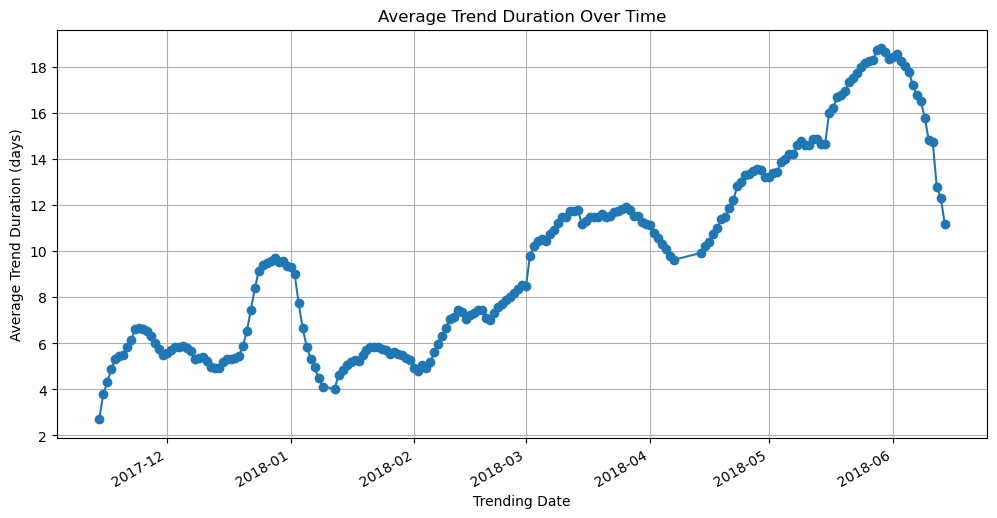

In [23]:
df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m')
trend_by_date = df.groupby('trending_date')['trend_duration'].mean()

plt.figure(figsize=(12,6))
trend_by_date.plot(marker='o')
plt.title('Average Trend Duration Over Time')
plt.xlabel('Trending Date')
plt.ylabel('Average Trend Duration (days)')
plt.grid(True)
plt.show()

#### 9. Data Cleaning & Merging of Canada Youtube Video Trends

We are interested in comparing trending patterns across different countries, using the US dataset as a reference. One approach is to merge datasets from multiple countries.

- Step 1: Clean dataset (similar to US dataset above)

- Step 2: Merge datasets by title name using inner join

*Challenge:*
Some videos appear in the trending data for multiple days. This results in multiple rows per video, which makes direct comparisons across countries difficult. Metrics like views and likes change daily, so we need to carefully decide how to aggregate or summarize video-level trends before merging.

In [25]:
df2 = pd.read_csv("CAvideos.csv", encoding='utf-8')

# Check for duplicates and missing values
df2.duplicated().sum(), df2.isna().sum()

# Keep unique videos for modeling whether a video trends
df_unique2 = df2.drop_duplicates(subset='video_id')

# Keep all records for trend-duration analysis
df_al2 = df2.copy()

# Drop unnecessary columns
df2 = df2.drop(['thumbnail_link','description'], axis=1)
df2 = df2.drop(['comments_disabled', 'ratings_disabled', 'video_error_or_removed'], axis=1)

# Convert trending_date from format 'yy.dd.mm' to datetime
df2['trending_date'] = pd.to_datetime(df2['trending_date'], format='%y.%d.%m', errors='coerce')

# Convert publish_time to datetime
df2['publish_time'] = pd.to_datetime(df2['publish_time'], errors='coerce')

# Ensure both datetime columns are timezone-naive (remove timezone info)
df2['publish_time'] = pd.to_datetime(df2['publish_time'], utc=True).dt.tz_localize(None)
df2['trending_date'] = pd.to_datetime(df2['trending_date'], format='%y.%d.%m', errors='coerce')

# Remove rows with missing essential data
df2 = df2.dropna(subset=['views', 'likes', 'dislikes', 'comment_count', 'publish_time', 'trending_date'])

# Remove invalid values
df2 = df2[(df2['views'] >= 0) & (df2['likes'] >= 0) & (df2['dislikes'] >= 0) & (df2['comment_count'] >= 0)]

# Load JSON file
with open("CA_category_id.json", "r") as f:
   data2 = json.load(f)

# Extract mapping: category_id → category_name
category_mapping2 = {int(item['id']): item['snippet']['title'] for item in data['items']}

# Map category names
df2['category_name'] = df2['category_id'].map(category_mapping)

df2.to_csv("cleaned_CAvideos_all.csv", index=False)


In [26]:
df2 = pd.read_csv("cleaned_CAvideos_all.csv", encoding='utf-8')

merged_df = pd.merge(df, df2, on='title', how='inner', suffixes=('_US', '_CA'))
print(merged_df.head(5))

   video_id_US trending_date_US  \
0  2kyS6SvSYSE       2017-11-14   
1  2kyS6SvSYSE       2017-11-14   
2  2kyS6SvSYSE       2017-11-14   
3  2kyS6SvSYSE       2017-11-14   
4  5qpjK5DgCt4       2017-11-14   

                                               title channel_title_US  \
0                 WE WANT TO TALK ABOUT OUR MARRIAGE     CaseyNeistat   
1                 WE WANT TO TALK ABOUT OUR MARRIAGE     CaseyNeistat   
2                 WE WANT TO TALK ABOUT OUR MARRIAGE     CaseyNeistat   
3                 WE WANT TO TALK ABOUT OUR MARRIAGE     CaseyNeistat   
4  Racist Superman | Rudy Mancuso, King Bach & Le...     Rudy Mancuso   

   category_id_US     publish_time_US  \
0              22 2017-11-13 17:13:01   
1              22 2017-11-13 17:13:01   
2              22 2017-11-13 17:13:01   
3              22 2017-11-13 17:13:01   
4              23 2017-11-12 19:05:24   

                                             tags_US  views_US  likes_US  \
0                          

## C. Data Limitations

This dataset represents only a snapshot of YouTube’s trending videos at the time of collection, rather than a complete record of all videos or long-term popularity trends. As a result, videos that never trended or trended outside the data collection period are excluded, which might lead to biasing insights toward more viral or mainstream content.

Additionally, because the data relies on the collector’s use of the YouTube API, there may be missing entries for certain days or regions if API requests failed or limits were reached. This could lead to incomplete or uneven coverage across time or geography.

Limitations:
- The dataset includes trending data for only nine countries (e.g., the United States, Great Britain, Japan, Korea, Mexico, Russia, Canada, etc.), so it doesn’t capture trends from other regions. In addition, we aren't able to access other countries' youtube pages thererfore we can't verify it's creditibility.


- Differences in local YouTube algorithms, cultural preferences, and platform usage may mean that findings based on these countries don’t generalize globally.


Impact:
These gaps can affect the representativeness and fairness of results. Analyses drawn from this dataset may overemphasize trends from certain countries or periods, potentially overlooking diverse viewing behaviors and creators from unrepresented regions.



## D. Questions for Reviewer:

1. Do you think it’s still feasible to merge datasets from different countries, given that we get multiple repeated rows per title because the same video can appear multiple times in one or both datasets (since YouTube trending data records one entry per day a video trends)?

2. What’s the best way to calculate trending days, considering that each row represents a single day a video trends? We’re considering using the longest trending date, but we also believe that tracking changes in metrics like likes over time is important for our analysis.

3. Which columns of data do you think we should look into to expand our analysis on factors that affect Youtube video popularity?